## Analysis list


~~Avg CV IKI by WF group~~  
    Difference between avg CV IKI for each WF group  
~~Avg CV IKI by BF group~~  
    Difference between avg CV IKI for each BF group  
~~CV IKI for each word~~  
    Words with lowest/highest CV IKI  
~~CV IKI for each bigram~~  
    ~~Bigrams with lowest/highest CV IKI~~  
Difference between CV IKI for each word group, between individuals  
Changes in IKI (delta IKI) across repetitions:  
    Across all words and within word groups  
    Delta IKI across repetitions for one IKI position within the word (rather than averaging across positions)  
visualize average cv changes across all IKI positions for each individual 
find average IKI values for each individual  

Avg. typing time per word  
    For all words  
    By WF  
    By BF  
Words typed the quickest/slowest
Avg. time typing per bigram  
    For all bigrams  
    By BF  
Bigrams typed quickest/slowest  

Avg. onset delay per trial  
    For all words  
    By WF  
    By BF  
Words with quickest/slowest onset delay  
Bigrams with quickest/slowest onset delay  

Total error #  
    by WF group  
    by BF group  
Words with highest error count  
Bigrams with highest error count  
Most common type of error  
    By WF group  
    By BF group  
Avg. edit distance of errors by WF and BF  

In [1]:
# importing experiment data
import numpy as np
import pandas as pd
import ast
import math
import matplotlib.pyplot as plt
from scipy.stats import variation
import glob
import os

import typingmod as typ
cwd = os.getcwd()

## IMPORTANT PRESETS
sID = 's20'

# og_df = pd.read_csv(cwd +
#                     'Desktop/Github/typingexp/typing_task_analysis/subject_data/raw/s175_08032022_test_typingtask_norepeats_2022_Aug_03_1805.csv')

# Desktop
og_df = pd.read_csv(r'/home/rubi/'
                        'Desktop/Github/typingexp/typing_task_analysis/subject_data/raw/s20_02082024_test_typingtask_norepeats_2024-02-08_11h14.35.066.csv')

## Laptop
# og_df = pd.read_csv(r'/Users/rubi/'
#                     'Desktop/Github/typingexp/typing_task_analysis/subject_data/raw/s224_04212023_test_typingtask_norepeats_2023_Apr_21_1302.csv')

f = glob.glob('subject_data/raw/%s*.csv' % sID)
og_df = pd.read_csv(f[0])

## Dataframe setup

In [2]:
### EDIT FOR ANY TRIALS YOU WANT TO IMMEDIATELY EXCLUDE ###

## deleting first 3 practice trials
df = (og_df.drop(labels=[0, 1, 2], axis=0)).reset_index(drop = True)

In [3]:
## expanding nested key_resp.rt values into separate columns, making new dataframe, and turning values back into floats from strings
stripped_rts_1 = ((df['key_resp_1.rt'].str.strip('[,]')).dropna()).str.split(',', expand = True)
stripped_rts_2 = ((df['key_resp_2.rt'].str.strip('[,]')).dropna()).str.split(',', expand = True)
rts_intocolumns = (pd.concat([stripped_rts_1, stripped_rts_2])).reset_index(drop = True)

## renames rt columns to automatically match dataset
DF = rts_intocolumns
renamed_rt = DF.rename(columns = { 0:'key_resp.rt.%s' %(0+1) })
for n in range(0, len(DF.columns)):
    renamed_rt = renamed_rt.rename(columns = { n:'key_resp.rt.%s' %(n+1) })
expanded_rts = renamed_rt.astype(float).fillna(0) ##replacing NaNs with zeroes

## expanding nested key_resp.keys values into separate columns and making new dataframe
stripped_keys_1 = ((df['key_resp_1.keys'].str.strip('[,]')).dropna()).str.split(',', expand = True)
stripped_keys_2 = ((df['key_resp_2.keys'].str.strip('[,]')).dropna()).str.split(',', expand = True)
keys_intocolumns = (pd.concat([stripped_keys_1, stripped_keys_2])).reset_index(drop = True)
keys_intocolumns = keys_intocolumns.where(pd.notnull(keys_intocolumns), None) 
    # ^ also replaces any added NaNs with Nones

## renames key columns to automatically match dataset
DF = keys_intocolumns
expanded_keys = DF.rename(columns = { 0:'key_resp.keys.%s' %(0+1) })
for n in range(0, len(DF.columns)):
    expanded_keys = expanded_keys.rename(columns = { n:'key_resp.keys.%s' %(n+1) })
    
## getting rid of apostrophes and spaces in key values
cols_to_change = (expanded_keys.iloc[:, 0:])
for col in cols_to_change:
    expanded_keys[col] = expanded_keys[col].str.replace("'", "")
    expanded_keys[col] = expanded_keys[col].str.replace(" ", "")
    
## combining key_resp.keys into one simple string to easily represent typed responses
responses_1 = pd.DataFrame((df['key_resp_1.keys'].str.replace("[', ]", "", regex=True).str.strip("[]")).dropna()).rename(columns = {'key_resp_1.keys':'resp_string'})
responses_2 = pd.DataFrame((df['key_resp_2.keys'].str.replace("[', ]", "", regex=True).str.strip("[]")).dropna()).rename(columns = {'key_resp_2.keys':'resp_string'})
responses = (pd.concat([responses_1, responses_2])).reset_index(drop = True)

## identifying bigrams in words to add to larger dataframe
## defining function that separates words in to bigrams
def bi_byword(word):
    bi_results = []
    for y in range(0, (len(word)-1)):
        bigram = word[y] + word[y+1]
        bi_results.append(bigram)
    return bi_results

## defining function that separates all words into bigrams
def bi_allwords():
    bigrams = []
    for word in df['string']:
        bigrams.append(bi_byword(word))
    return bigrams

task_bigrams = pd.DataFrame(bi_allwords())
task_bigrams.columns = ['bi_1', 'bi_2', 'bi_3', 'bi_4']

In [4]:
## combining expanded rt, expanded keys, and response string values with column for strings typed each trial to create more useful dataframe
    ## (does not have all the random timing data of other events occuring during the task)
main_df = pd.concat([task_bigrams, expanded_keys, expanded_rts, responses], axis = 1)
main_df.insert(0, 'string', df['string'], True)

## creating column for WF type for each trial
main_df['WF Type'] = ""
for index, data in main_df.iterrows():
    if main_df.loc[index, 'string'] in typ.highwf:
        main_df.loc[index, 'WF Type'] = 'highwf'
    if main_df.loc[index, 'string'] in typ.medwf:
        main_df.loc[index, 'WF Type'] = 'medwf'
    if main_df.loc[index, 'string'] in typ.lowwf:
        main_df.loc[index, 'WF Type'] = 'lowwf'
    if main_df.loc[index, 'string'] in typ.pseudo:
        main_df.loc[index, 'WF Type'] = 'pseudo'

## creating column for BF type for each trial
main_df['BF Type'] = ""
for index, data in main_df.iterrows():
    if main_df.loc[index, 'string'] in typ.highbf:
        main_df.loc[index, 'BF Type'] = 'highbf'
    if main_df.loc[index, 'string'] in typ.medbf:
        main_df.loc[index, 'BF Type'] = 'medbf'
    if main_df.loc[index, 'string'] in typ.lowbf:
        main_df.loc[index, 'BF Type'] = 'lowbf'
        
## creating column for trial (useful for group analysis)
trial_nums = []
for index, data in main_df.iterrows():
    trial_nums.append(index)
main_df.insert(0, 'Trial #', trial_nums)

## creating column for subject ID (also useful for group analysis)
main_ID = [sID]*len(main_df)
main_df.insert(0, 'sID', main_ID)

In [5]:
## making csv from dataframe
main_path = 'subject_data/main_dfs/%s_maindf.csv' % (sID)
main_df.to_csv(main_path)
main_df
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can also be specified
#     print(main_df)

,sID,Trial #,string,bi_1,bi_2,bi_3,bi_4,key_resp.keys.1,key_resp.keys.2,key_resp.keys.3,...,key_resp.rt.1,key_resp.rt.2,key_resp.rt.3,key_resp.rt.4,key_resp.rt.5,key_resp.rt.6,key_resp.rt.7,resp_string,WF Type,BF Type
0,s20,0,think,th,hi,in,nk,t,h,i,...,1.033429,1.097404,1.209389,1.377308,1.609413,0.0,0.0,think,highwf,
1,s20,1,heond,he,eo,on,nd,h,e,o,...,1.035436,1.155472,1.219402,1.419424,1.755490,0.0,0.0,heond,pseudo,
2,s20,2,zibja,zi,ib,bj,ja,z,i,b,...,1.246242,1.318313,1.486308,1.718317,1.830190,0.0,0.0,zibja,pseudo,
3,s20,3,edthe,ed,dt,th,he,e,d,t,...,1.043251,1.163339,1.243263,1.435344,1.531305,0.0,0.0,edthe,pseudo,
4,s20,4,there,th,he,er,re,t,h,e,...,0.951296,1.031302,1.151299,1.215358,1.375306,0.0,0.0,there,highwf,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,s20,235,cooed,co,oo,oe,ed,c,o,o,...,0.663655,0.791603,0.935634,1.023607,1.119597,0.0,0.0,cooed,lowwf,
236,s20,236,buddy,bu,ud,dd,dy,b,u,d,...,0.979553,1.107571,1.347614,1.515652,1.603761,0.0,0.0,buddy,highwf,
237,s20,237,vanru,va,an,nr,ru,v,a,n,...,0.879306,1.015307,1.119352,1.303288,1.407302,0.0,0.0,vanru,pseudo,
238,s20,238,belly,be,el,ll,ly,b,e,l,...,0.731402,0.875451,0.995498,1.139481,1.603471,0.0,0.0,bellu,medwf,


In [6]:
## make dataframe of bigram IKIs
## bigram / trial # / string / IKI / bf type / resp_string / string type / bigram location in word
def bigram_byrow():
    bigrams = []
    for index, row in keys_intocolumns.iterrows():
        for column in range(0, (len(keys_intocolumns.columns) - 1)):
            if (keys_intocolumns[column][index] != None and float('nan')) and (keys_intocolumns[column + 1][index] != None and float('nan')):
                bigram = keys_intocolumns[column][index] + keys_intocolumns[column + 1][index]
                iki = (main_df['key_resp.rt.%(second)d' % {'second':  column + 2 }][index] - main_df['key_resp.rt.%(first)d' % { 'first': column +1 }][index])
                bigrams.append([index, column, bigram, iki, main_df['string'][index], main_df['resp_string'][index]])
    return(bigrams)
    
bigram_df = (pd.DataFrame(bigram_byrow())).rename(columns={0: "Trial #", 1: "bigram_loc",  2:"Bigram", 3: "IKI", 4: "string", 5: "resp_string"})

## creating column for bigram # (useful for group analysis)
bigram_nums = []
for index, data in bigram_df.iterrows():
    bigram_nums.append(index)
bigram_df.insert(0, 'Bigram #', bigram_nums)

## creating column for subject ID (also useful for group analysis)
bigram_ID = [sID]*len(bigram_df)
bigram_df.insert(0, 'sID', bigram_ID)

## creating column for rep #
bigram_df['rep #'] = ''
for string in typ.all_strings:
    by_string = bigram_df[bigram_df.string == string]
    trials = list(set(by_string['Trial #']))
    trials.sort()
    for trial in trials:
        by_rep = by_string[by_string['Trial #'] == trial]
        rows = by_rep.index
        bigram_df.loc[rows, 'rep #'] = trials.index(trial)
        
## creating column for correct bigram (as opposed to the typed bigram)
bigram_df.insert(5, 'corr_bigram', '')
for index, row in bigram_df.iterrows():
    loc = bigram_df.loc[index, 'bigram_loc']
    loc_list = [0, 1, 2, 3]
    if loc in loc_list:
        corr = bi_byword(bigram_df.loc[index, 'string'])[loc]
    else:
        corr = ''
    bigram_df.loc[index, 'corr_bigram'] = corr
    
## creating column for bigram frequency
bg_freqs = pd.read_csv(cwd + '/bg_freqs.csv')
bg_freqs.drop(columns = ['Unnamed: 0'], inplace = True)

bigram_df['bg_freq'] = ''
for index, row in bg_freqs.iterrows():
    by_bg = bigram_df[bigram_df.corr_bigram == row[0]]
    rows = by_bg.index
    bigram_df.loc[rows, 'bg_freq'] = row[1]
    
## creating column for bigram type
name_list = ['high', 'med', 'low', 'pseudo']

for index, bf_type in enumerate(typ.bf_types):
    by_bf = bigram_df[bigram_df.corr_bigram.isin(bf_type)]
    rows = by_bf.index
    bigram_df.loc[rows, 'bf_type'] = name_list[index]

## creating a column for mean bigram type
for index, avgbf_type in enumerate(typ.avgbf_types):
    by_bf = bigram_df[bigram_df.string.isin(avgbf_type)]
    rows = by_bf.index
    bigram_df.loc[rows, 'meanbf_type'] = name_list[index]
    
## creating a column for mean bigram type
for index, wf_type in enumerate(typ.wf_types):
    by_wf = bigram_df[bigram_df.string.isin(wf_type)]
    rows = by_wf.index
    bigram_df.loc[rows, 'wf_type'] = name_list[index]

## making csv from dataframe
bigram_path = 'subject_data/bigram_dfs/%s_bigramdf.csv' % (sID)
bigram_df.to_csv(bigram_path)
bigram_df

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can also be specified
#     print(bigram_df)

,sID,Bigram #,Trial #,bigram_loc,Bigram,corr_bigram,IKI,string,resp_string,rep #,bg_freq,bf_type,meanbf_type,wf_type
0,s20,0,0,0,'t' 'h',th,0.063975,think,think,0,22288309,high,high,high
1,s20,1,0,1,'h' 'i',hi,0.111985,think,think,0,6198006,high,high,high
2,s20,2,0,2,'i' 'n',in,0.167919,think,think,0,13597302,high,high,high
3,s20,3,0,3,'n' 'k',nk,0.232104,think,think,0,445067,low,high,high
4,s20,4,1,0,'h' 'e',he,0.120036,heond,heond,0,21484684,high,high,pseudo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
966,s20,966,238,3,'l' 'u',ly,0.463990,belly,bellu,9,2589130,med,med,med
967,s20,967,239,0,'d' 'r',dr,0.160077,druze,druze,9,567936,med,low,low
968,s20,968,239,1,'r' 'u',ru,0.103966,druze,druze,9,705492,med,low,low
969,s20,969,239,2,'u' 'z',uz,0.184098,druze,druze,9,19836,low,low,low


In [7]:
## making filtered dataframes
all_rts = typ.rt_columns(main_df)

corr_df = typ.correct_filter(main_df) ## only correct trials
incorr_df = typ.incorrect_filter(main_df) ## only incorrect trials

corr_rts = typ.rt_columns(corr_df) ## only correct rts
incorr_rts = typ.rt_columns(incorr_df) ## only incorrect rts

## making filtered dataframes by word frequency
highwf_df = main_df[main_df['string'].isin(typ.highwf)]
medwf_df = main_df[main_df['string'].isin(typ.medwf)]
lowwf_df = main_df[main_df
                   ['string'].isin(typ.lowwf)]
pseudo_df = main_df[main_df['string'].isin(typ.pseudo)]

In [8]:
# ## making dataframe of only rts from all trials
# all_rts = expanded_rts
# ## inserting column containing the string typed during each trial, if it hasn't already been inserted
# if ((all_rts.iloc[:, 0]).dtype) != object:
#     all_rts.insert(0, 'string', df['string'], True)

## making dataframes with rts by word frequency type
highwf_rts = (typ.rt_columns(highwf_df)).reset_index(drop=True)
medwf_rts = (typ.rt_columns(medwf_df)).reset_index(drop=True)
lowwf_rts = (typ.rt_columns(lowwf_df)).reset_index(drop=True)
pseudo_rts = (typ.rt_columns(pseudo_df)).reset_index(drop=True)

## IKI Variables by Word and Word Type (WF and BF)

In [9]:
## WIP -- need to get strings out of list to get mean

# defining function to find average IKI across all string positions for each trial
# def avg_iki(str_type, DF):
#     all_ikis = iki(DF)
#     sort_byword = []
#     for index, data in all_ikis.iterrows():
#             if all_ikis['string'][index] in str_type:
#                 sort_byword.append(data)
#     iki_byword = pd.DataFrame(sort_byword)
#     iki_byword.reset_index(drop=True, inplace=True)
#     iki_list = iki_byword.values.tolist()
#     iki_avgs = sum(iki_list)/len(iki_list)
#     return iki_avgs

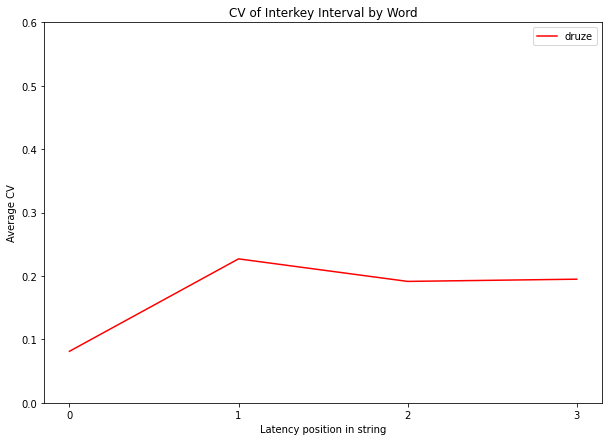

In [10]:
## creating dataframe from 'cv_byword' function that is easy to plot
cv_word = 'druze' # change this for which ever word you want to plot
cv_byword_df = (pd.DataFrame(typ.cv_byword(cv_word, corr_rts)).drop(0)).reset_index(drop = True)

## plotting digraph latency variations by word (does not include error trials)
plt.figure(figsize=(10, 7))
x = [0, 1, 2, 3]
highwf_plot = plt.plot(cv_byword_df, color='red', label=cv_word)
# medwf_plot = plt.plot(cv_byword_df, color='red', label='There')

plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.xlabel("Latency position in string")
plt.ylabel("Average CV")
plt.ylim([0, 0.6])
plt.title("CV of Interkey Interval by Word")
plt.legend(loc="best")

plt.show()

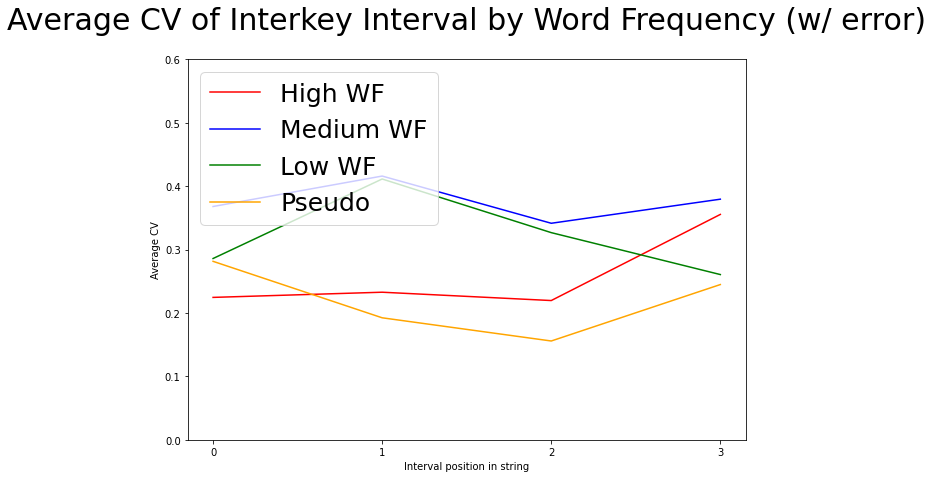

In [11]:
## plotting digraph latency variations by WF type (includes error trials)
## NOTE: run twice for tick marks / label sizes to update -- dunno why
plt.figure(figsize=(10, 7))
x = [0, 1, 2, 3]
highwf_plot = plt.plot(typ.avg_cv(typ.highwf, all_rts), color='red', label='High WF')
medwf_plot = plt.plot(typ.avg_cv(typ.medwf, all_rts), color='blue', label='Medium WF')
lowwf_plot = plt.plot(typ.avg_cv(typ.lowwf, all_rts), color='green', label='Low WF')
pseudo_plot = plt.plot(typ.avg_cv(typ.pseudo, all_rts), color='orange', label='Pseudo')

## Set general font size
plt.rcParams['font.size'] = '25'

## Set tick font size
# for label in (ax.get_xticklabels() + ax.get_yticklabels()):
#     label.set_fontsize(25)

plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.xlabel("Interval position in string")
plt.ylabel("Average CV")
plt.ylim([0, 0.6])
plt.title("Average CV of Interkey Interval by Word Frequency (w/ error)", pad=30)
plt.legend(loc="best")

# plt.savefig('ian_iki.png')

plt.show()

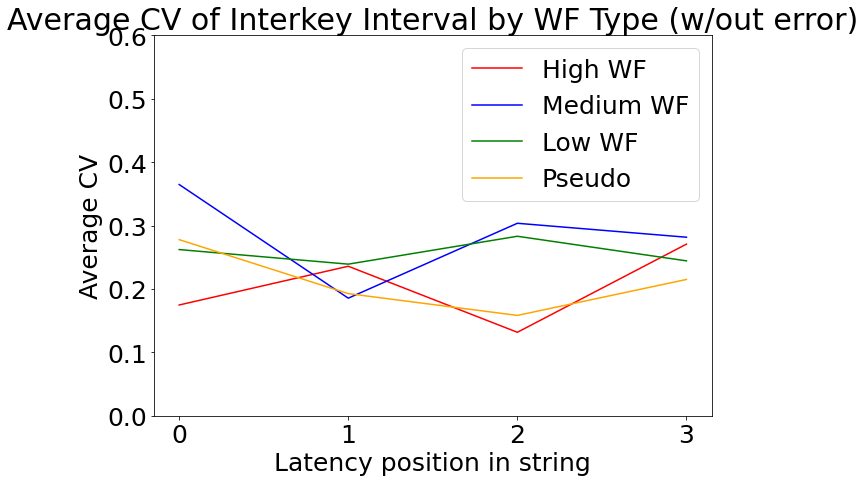

In [12]:
## plotting digraph latency variations by WF type (does not include error trials)
plt.figure(figsize=(10, 7))
x = [0, 1, 2, 3]
highwf_plot = plt.plot(typ.avg_cv(typ.highwf, corr_rts), color='red', label='High WF')
medwf_plot = plt.plot(typ.avg_cv(typ.medwf, corr_rts), color='blue', label='Medium WF')
lowwf_plot = plt.plot(typ.avg_cv(typ.lowwf, corr_rts), color='green', label='Low WF')
pseudo_plot = plt.plot(typ.avg_cv(typ.pseudo, corr_rts), color='orange', label='Pseudo')


plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.xlabel("Latency position in string")
plt.ylabel("Average CV")
plt.ylim([0, 0.6])
plt.title("Average CV of Interkey Interval by WF Type (w/out error)")
plt.legend(loc="best")

plt.show()

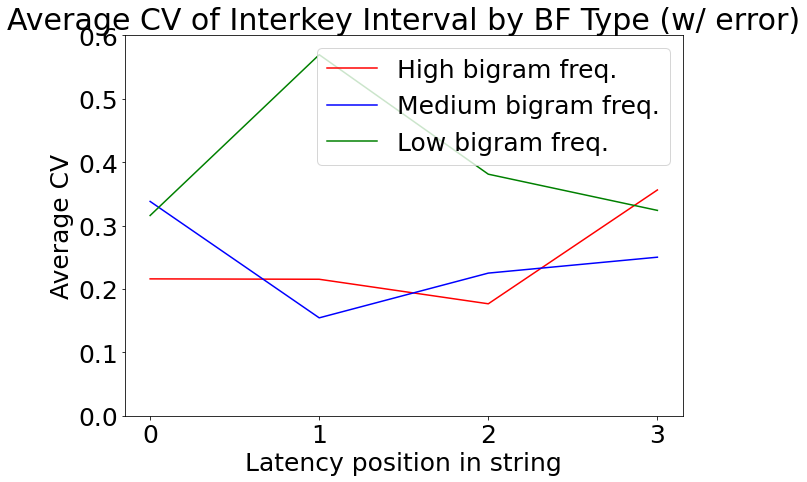

In [13]:
## plotting digraph latency variations by Avg BF type (includes error trials)
plt.figure(figsize=(10, 7))
x = [0, 1, 2, 3]
highbf_plot = plt.plot(typ.avg_cv(typ.high_avgbf, all_rts), color='red', label='High bigram freq.')
medbf_plot = plt.plot(typ.avg_cv(typ.med_avgbf, all_rts), color='blue', label='Medium bigram freq.')
lowbf_plot = plt.plot(typ.avg_cv(typ.low_avgbf, all_rts), color='green', label='Low bigram freq.')

plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.xlabel("Latency position in string")
plt.ylabel("Average CV")
plt.ylim([0, 0.6])
plt.title("Average CV of Interkey Interval by BF Type (w/ error)")
plt.legend(loc="best")

plt.show()

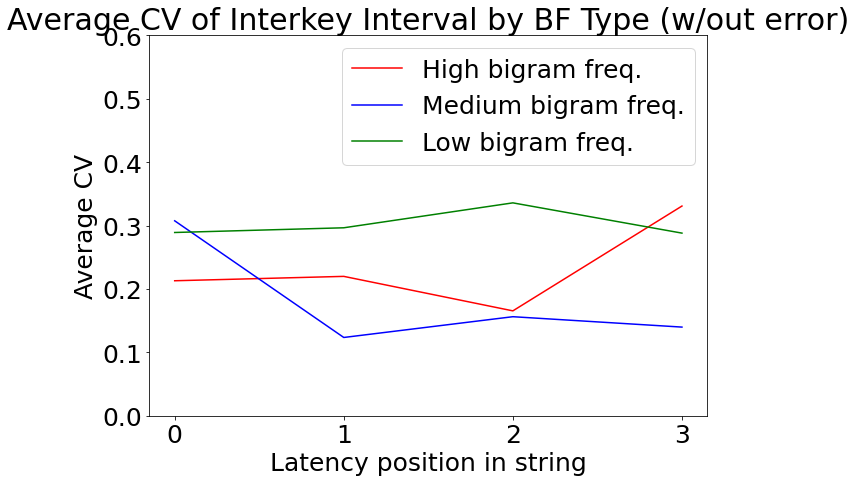

In [14]:
## plotting digraph latency variations by Avg BF type (does not include error trials)
plt.figure(figsize=(10, 7))
x = [0, 1, 2, 3]
highbf_plot = plt.plot(typ.avg_cv(typ.high_avgbf, corr_rts), color='red', label='High bigram freq.')
medbf_plot = plt.plot(typ.avg_cv(typ.med_avgbf, corr_rts), color='blue', label='Medium bigram freq.')
lowbf_plot = plt.plot(typ.avg_cv(typ.low_avgbf, corr_rts), color='green', label='Low bigram freq.')


plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.xlabel("Latency position in string")
plt.ylabel("Average CV")
plt.ylim([0, 0.6])
plt.title("Average CV of Interkey Interval by BF Type (w/out error)")
plt.legend(loc="upper right")

plt.show()

## IKI Variables by Bigram

In [15]:
## making dataframe of bigram cv ikis and organizing in descending order
bigram_cvs = (pd.DataFrame(typ.cv_allbgs(bigram_df))).rename(columns = {0 : "Bigram", 1 : "CV IKI"}).sort_values(by = ['CV IKI'], ignore_index = True)
bigram_cvs

,Bigram,CV IKI
0,ol,0.065488
1,kk,0.071866
2,dd,0.073742
3,dr,0.081197
4,wo,0.087389
...,...,...
68,re,0.859579
69,pp,0.963599
70,up,1.199131
71,od,1.260402


In [16]:
## creating dataframes with bigram cv iki maxima and minima
bg_maxima = bigram_cvs.loc[0:4]
bg_minima = bigram_cvs.loc[65:69]
bg_maxima

,Bigram,CV IKI
0,ol,0.065488
1,kk,0.071866
2,dd,0.073742
3,dr,0.081197
4,wo,0.087389


In [17]:
bg_minima

,Bigram,CV IKI
65,vo,0.634868
66,uc,0.651464
67,it,0.726452
68,re,0.859579
69,pp,0.963599


## Onset Delay Variables

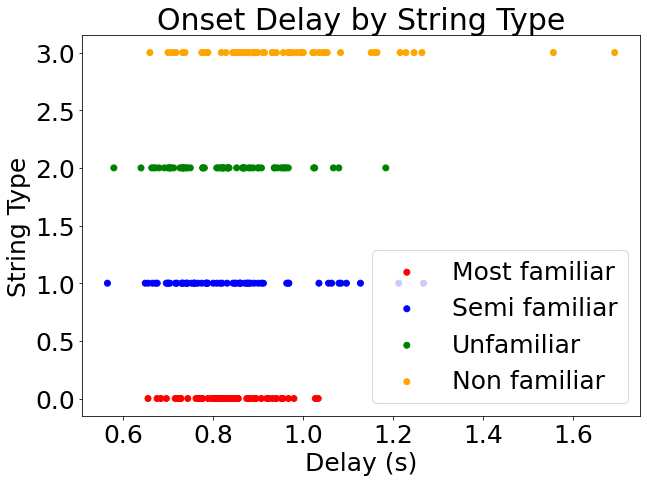

In [18]:
## plotting onset delay by wf type as scatter plot
plt.figure(figsize=(10, 7))
highwf_scatter = plt.scatter(typ.onset_delay(highwf_df), [0] * len(typ.onset_delay(highwf_df)), c=['red'] * len(typ.onset_delay(highwf_df)), label='Most familiar')
medwf_scatter = plt.scatter((typ.onset_delay(medwf_df)), [1] * len(typ.onset_delay(medwf_df)), c=['blue'] * len(typ.onset_delay(medwf_df)), label='Semi familiar')
lowwf_scatter = plt.scatter((typ.onset_delay(lowwf_df)), [2] * len(typ.onset_delay(lowwf_df)), c=['green'] * len(typ.onset_delay(lowwf_df)), label='Unfamiliar')
pseudo_scatter = plt.scatter((typ.onset_delay(pseudo_df)), [3] * len(typ.onset_delay(pseudo_df)), c=['orange'] * len(typ.onset_delay(pseudo_df)), label='Non familiar')

plt.xlabel("Delay (s)")
plt.ylabel("String Type")
plt.title("Onset Delay by String Type")
plt.legend(loc = "best")

plt.show()

Text(0.5, 1.0, 'Onset Delay by String Type')

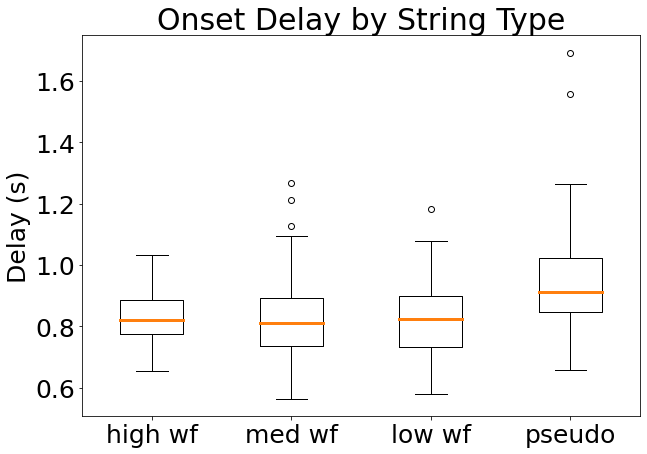

In [19]:
## plotting onset delay as box and whisker
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)
bp = ax.boxplot([ typ.onset_delay(highwf_df), typ.onset_delay(medwf_df), typ.onset_delay(lowwf_df), typ.onset_delay(pseudo_df)])

colors = ['#0000FF', '#00FF00','#FFFF00', '#FF00FF']

ax.set_xticklabels(['high wf', 'med wf',
                    'low wf', 'pseudo'])
for median in bp['medians']:
    
    median.set(linewidth = 3)

plt.xlabel("")
plt.ylabel("Delay (s)")
plt.title("Onset Delay by String Type")

## Typing Time Variables

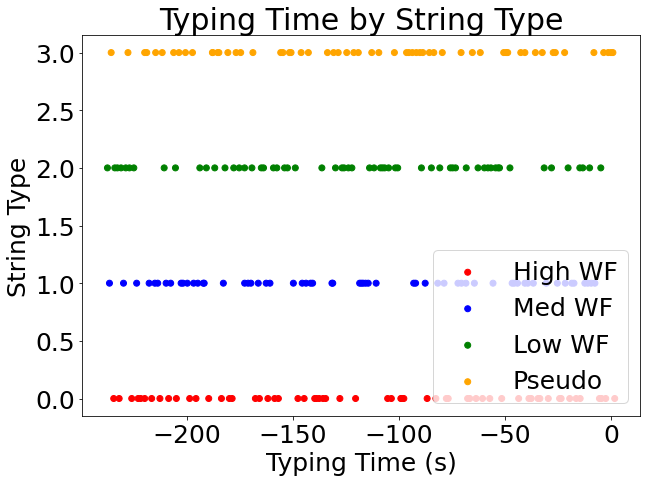

In [20]:
## plotting scatter plot of typing time with legend
plt.figure(figsize=(10, 7))
highwf_scatter = plt.scatter(typ.time_typing(highwf_rts), [0] * len(typ.time_typing(highwf_rts)), c=['red'] * len(typ.time_typing(highwf_rts)), label='High WF')
medwf_scatter = plt.scatter(typ.time_typing(medwf_rts), [1] * len(typ.time_typing(medwf_rts)), c=['blue'] * len(typ.time_typing(medwf_rts)), label='Med WF')
lowwf_scatter = plt.scatter(typ.time_typing(lowwf_rts), [2] * len(typ.time_typing(lowwf_rts)), c=['green'] * len(typ.time_typing(lowwf_rts)), label='Low WF')
pseudo_scatter = plt.scatter(typ.time_typing(pseudo_rts), [3] * len(typ.time_typing(pseudo_rts)), c=['orange'] * len(typ.time_typing(pseudo_rts)), label='Pseudo')

plt.xlabel("Typing Time (s)")
plt.ylabel("String Type")
plt.title("Typing Time by String Type")
plt.legend(loc= "lower right")

plt.show()

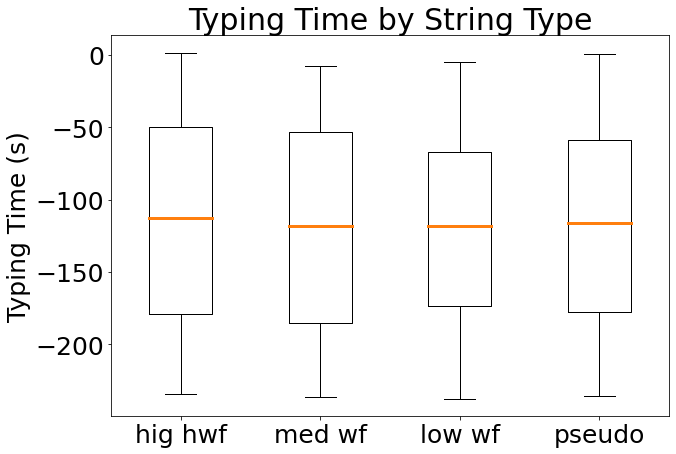

In [21]:
## plotting typing time as box and whisker
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)
bp = ax.boxplot([typ.time_typing(highwf_rts), typ.time_typing(medwf_rts), typ.time_typing(lowwf_rts), typ.time_typing(pseudo_rts)])

colors = ['#0000FF', '#00FF00','#FFFF00', '#FF00FF']

ax.set_xticklabels(['hig hwf', 'med wf',
                    'low wf', 'pseudo'])
for median in bp['medians']:
    median.set(linewidth = 3)
    
plt.xlabel("")
plt.ylabel("Typing Time (s)")
plt.title("Typing Time by String Type")

plt.show()

## Delta IKI Variables

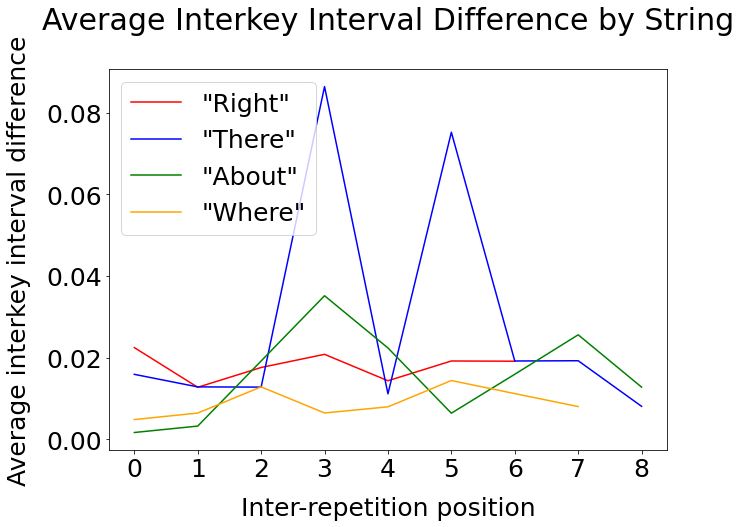

In [22]:
## plotting average delta IKI by WF type (only for correct trials)

plt.figure(figsize=(10, 7))
x = [0, 1, 2, 3, 4, 5, 6, 7, 8]
highwf_plot = plt.plot((typ.avg_diki_byword('think', corr_rts)), color='red', label='"Right"')
medwf_plot = plt.plot((typ.avg_diki_byword('there', corr_rts)), color='blue', label='"There"')
lowwf_plot = plt.plot((typ.avg_diki_byword('about', corr_rts)), color='green', label='"About"')
pseudo_plot = plt.plot((typ.avg_diki_byword('would', corr_rts)), color='orange', label='"Where"')


plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.xlabel("Inter-repetition position", labelpad=15)
plt.ylabel("Average interkey interval difference", labelpad=15)
# plt.ylim([0.1, 0.6])
plt.title("Average Interkey Interval Difference by String", pad=40)
plt.legend(loc="upper left")

plt.show()